In [1]:
# %% [markdown]
# # TFMS Stock Prediction - Data Integration
# Combines technical, fundamental, and sentiment data for enhanced prediction

# %%
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Create directories
os.makedirs("../data/processed/integrated", exist_ok=True)
os.makedirs("../data/results/figures", exist_ok=True)

# %% [markdown]
# ## Step 1: Load and Merge Datasets

# %%
# %% [markdown]
# ## Fixed Data Integration

# %%
def integrate_stock_data(ticker):
    """Fixed version with proper target calculation and gap handling"""
    try:
        # Load cleaned datasets
        technical = pd.read_csv(
            f"../data/processed/technical/{ticker}_technical_clean.csv",
            parse_dates=['Date']
        )
        fundamental = pd.read_csv(
            f"../data/processed/fundamental/{ticker}_fundamental_clean.csv",
            parse_dates=['date']
        )
        sentiment = pd.read_csv(
            f"../data/processed/sentiment/{ticker}_sentiment_clean.csv",
            parse_dates=['date']
        )

        # Convert to numeric timestamps
        technical['date_num'] = technical['Date'].astype('int64')
        fundamental['date_num'] = fundamental['date'].astype('int64')

        # Merge with 45-day tolerance (in nanoseconds)
        tolerance = int(45 * 24 * 60 * 60 * 1e9)
        merged = pd.merge_asof(
            technical.sort_values('date_num'),
            fundamental.sort_values('date_num'),
            left_on='date_num',
            right_on='date_num',
            direction='nearest',
            tolerance=tolerance
        )

        # Add sentiment with forward fill (news sentiment persists until new news)
        merged = pd.merge_asof(
            merged.sort_values('Date'),
            sentiment.sort_values('date'),
            left_on='Date',
            right_on='date',
            direction='forward'
        )

        # Calculate PROPER target variable (avoid future peeking)
        merged['target_5day_return'] = merged['Close'].pct_change(5).shift(-5)
        
        # Remove last 5 rows where target is unknowable
        merged = merged.iloc[:-5] if len(merged) > 5 else merged

        # Fill fundamental gaps (quarterly data)
        merged['debt_to_equity'] = merged['debt_to_equity'].ffill()
        
        # Fill technical indicator gaps
        for col in ['RSI_14', 'SMA_20']:
            merged[col] = merged[col].interpolate()
            
        # Fill sentiment with neutral (0) if missing
        merged['sentiment_score'] = merged['sentiment_score'].fillna(0)
        merged['sentiment_3day_ma'] = merged['sentiment_score'].rolling(3, min_periods=1).mean()

        # Final cleanup
        merged = merged.drop(columns=['date_num', 'date_x', 'date_y'])
        merged.to_csv(f"../data/processed/integrated/{ticker}_integrated.csv", index=False)
        
        print(f"✅ {ticker}: Integrated {len(merged)} rows | Target range: {merged['target_5day_return'].min():.2f} to {merged['target_5day_return'].max():.2f}")
        return merged
        
    except Exception as e:
        print(f"❌ {ticker} failed: {str(e)}")
        return None

# Re-process all stocks
for ticker in ['AAPL', 'JPM', 'AMZN', 'PFE', 'XOM']:
    integrate_stock_data(ticker)

# Process all stocks
tickers = ['AAPL', 'JPM', 'AMZN', 'PFE', 'XOM']
integrated_dfs = {}

for ticker in tickers:
    df = integrate_stock_data(ticker)
    if df is not None:
        integrated_dfs[ticker] = df
        df.to_csv(f"../data/processed/integrated/{ticker}_integrated.csv", index=False)
        print(f"✅ {ticker}: Integrated {len(df)} rows")



✅ AAPL: Integrated 1138 rows | Target range: -0.23 to 0.17
✅ JPM: Integrated 1138 rows | Target range: -0.14 to 0.17
✅ AMZN: Integrated 1138 rows | Target range: -0.20 to 0.18
✅ PFE: Integrated 1138 rows | Target range: -0.11 to 0.18
✅ XOM: Integrated 1138 rows | Target range: -0.15 to 0.16
✅ AAPL: Integrated 1138 rows | Target range: -0.23 to 0.17
✅ AAPL: Integrated 1138 rows
✅ JPM: Integrated 1138 rows | Target range: -0.14 to 0.17
✅ JPM: Integrated 1138 rows
✅ AMZN: Integrated 1138 rows | Target range: -0.20 to 0.18
✅ AMZN: Integrated 1138 rows
✅ PFE: Integrated 1138 rows | Target range: -0.11 to 0.18
✅ PFE: Integrated 1138 rows
✅ XOM: Integrated 1138 rows | Target range: -0.15 to 0.16
✅ XOM: Integrated 1138 rows


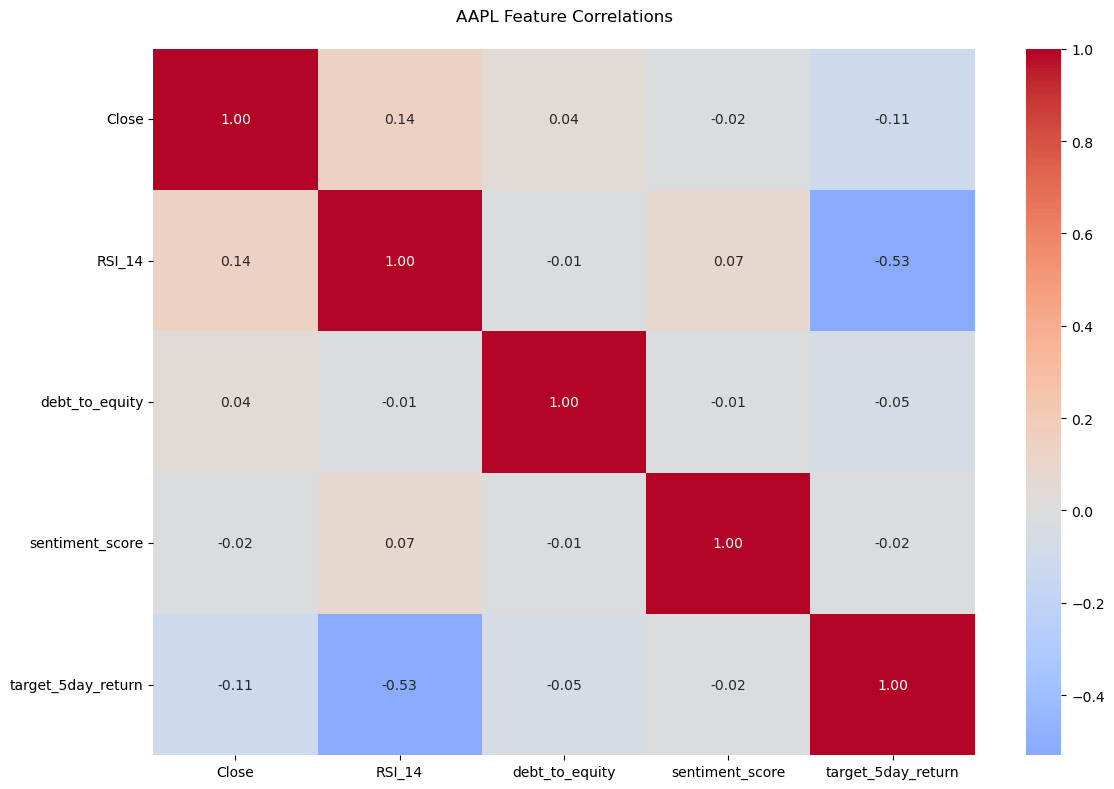

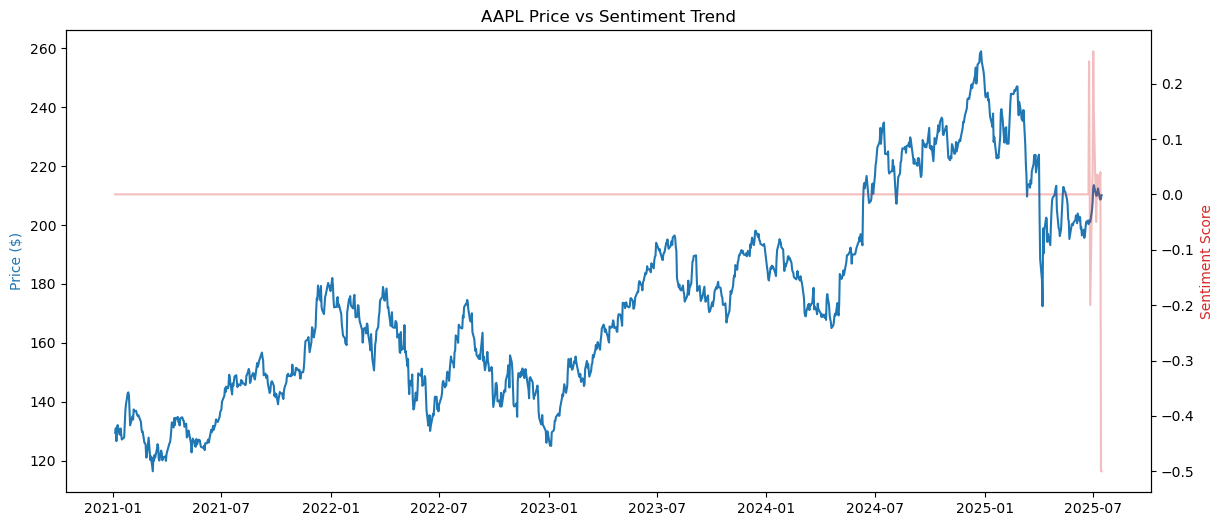

In [2]:
# %% [markdown]
# ## Step 2: Visualizations

# %%
# Correlation Heatmap (Example for AAPL)
plt.figure(figsize=(12,8))
corr_matrix = integrated_dfs['AAPL'][[
    'Close', 'RSI_14', 'debt_to_equity', 'sentiment_score', 'target_5day_return'
]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("AAPL Feature Correlations", pad=20)
plt.tight_layout()
plt.savefig("../data/results/figures/correlation_heatmap.png", dpi=300)
plt.show()

# %%
# Price-Sentiment Timeline (Example for AAPL)
plt.figure(figsize=(14,6))
plt.plot(integrated_dfs['AAPL']['Date'], 
         integrated_dfs['AAPL']['Close'], 
         label='Price', color='tab:blue')
plt.ylabel('Price ($)', color='tab:blue')
plt.twinx()
plt.plot(integrated_dfs['AAPL']['Date'], 
         integrated_dfs['AAPL']['sentiment_score'], 
         label='Sentiment', color='tab:red', alpha=0.3)
plt.ylabel('Sentiment Score', color='tab:red')
plt.title("AAPL Price vs Sentiment Trend")
plt.savefig("../data/results/figures/price_sentiment_trend.png", dpi=300)
plt.show()

In [3]:
for ticker in ['AAPL', 'JPM', 'AMZN', 'PFE', 'XOM']:
    df = pd.read_csv(f"../data/processed/integrated/{ticker}_integrated.csv", parse_dates=['Date'])
    print(f"\n{ticker} Target Variable Check:")
    print(df[['Date', 'Close', 'target_5day_return']].tail(5))


AAPL Target Variable Check:
           Date   Close  target_5day_return
1133 2025-07-10  212.41           -0.011252
1134 2025-07-11  211.16            0.000095
1135 2025-07-14  208.62            0.018503
1136 2025-07-15  209.11            0.025298
1137 2025-07-16  210.16            0.018986

JPM Target Variable Check:
           Date   Close  target_5day_return
1133 2025-07-10  288.19            0.005934
1134 2025-07-11  286.86            0.015373
1135 2025-07-14  288.70            0.007863
1136 2025-07-15  286.55            0.017030
1137 2025-07-16  285.82            0.038276

AMZN Target Variable Check:
           Date   Close  target_5day_return
1133 2025-07-10  222.26            0.007289
1134 2025-07-11  225.02            0.004933
1135 2025-07-14  225.69            0.015995
1136 2025-07-15  226.35            0.004948
1137 2025-07-16  223.19            0.022850

PFE Target Variable Check:
           Date  Close  target_5day_return
1133 2025-07-10  25.78           -0.046548
1134 202

In [4]:
for ticker in ['AAPL', 'JPM', 'AMZN', 'PFE', 'XOM']:
    df = pd.read_csv(f"../data/processed/integrated/{ticker}_integrated.csv")
    print(f"\n{ticker} Missing Values:")
    print(df[['RSI_14', 'SMA_20', 'debt_to_equity', 'sentiment_3day_ma', 'target_5day_return']].isnull().sum())


AAPL Missing Values:
RSI_14                  0
SMA_20                  0
debt_to_equity        155
sentiment_3day_ma       0
target_5day_return      0
dtype: int64

JPM Missing Values:
RSI_14                0
SMA_20                0
debt_to_equity        0
sentiment_3day_ma     0
target_5day_return    0
dtype: int64

AMZN Missing Values:
RSI_14                0
SMA_20                0
debt_to_equity        0
sentiment_3day_ma     0
target_5day_return    0
dtype: int64

PFE Missing Values:
RSI_14                0
SMA_20                0
debt_to_equity        0
sentiment_3day_ma     0
target_5day_return    0
dtype: int64

XOM Missing Values:
RSI_14                0
SMA_20                0
debt_to_equity        0
sentiment_3day_ma     0
target_5day_return    0
dtype: int64


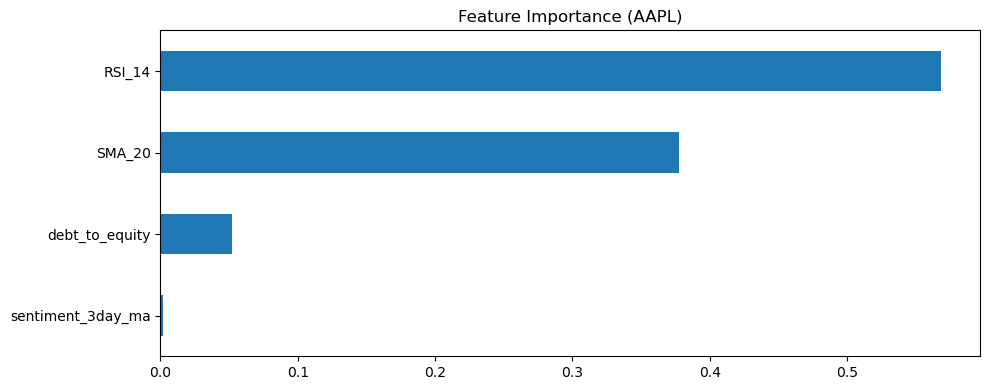

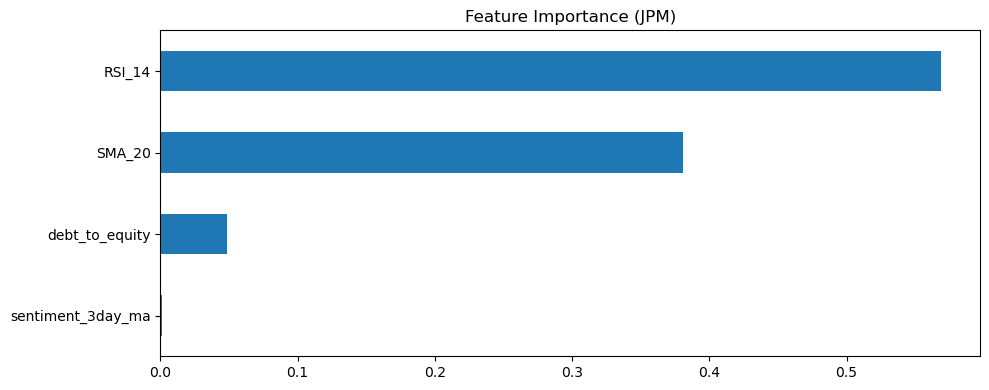

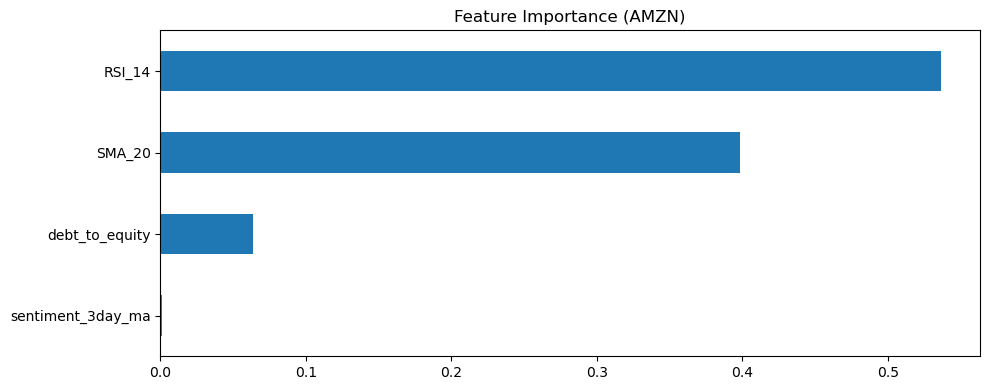

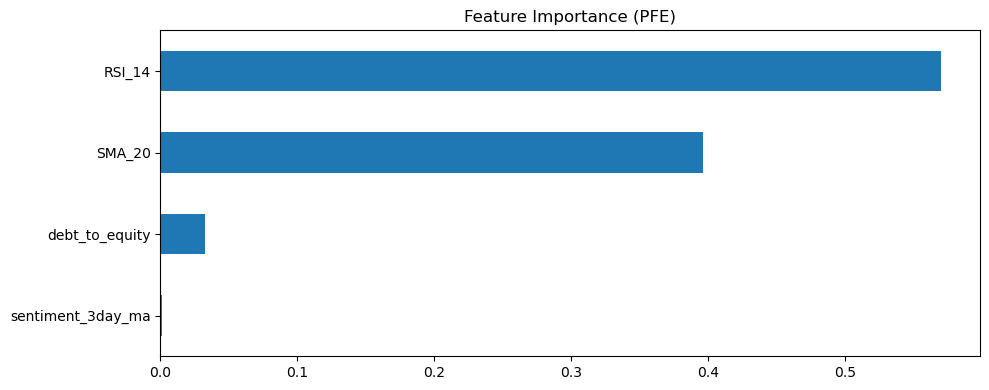

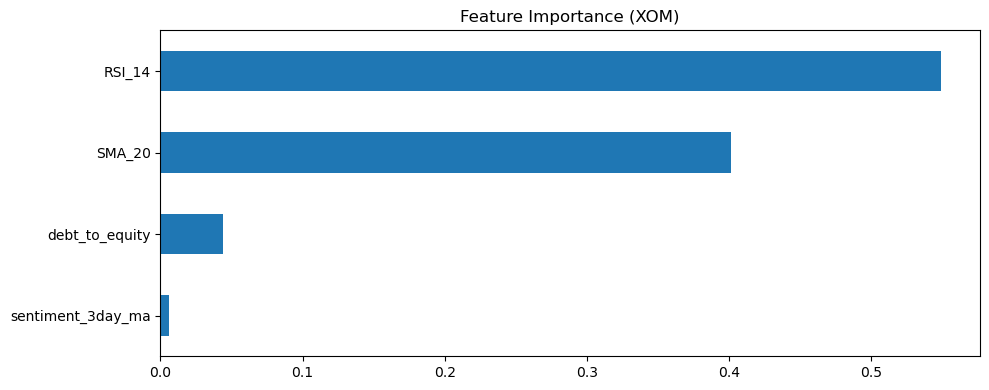

In [5]:
# %% [markdown]
# ## Step 3: Feature Importance Analysis (Fixed)

# %%
from sklearn.ensemble import RandomForestRegressor

def analyze_feature_importance(ticker):
    """Robust feature importance analysis with data validation"""
    try:
        # Load integrated data
        df = integrated_dfs[ticker]
        
        # Prepare features and target
        features = df[[
            'RSI_14', 'SMA_20', 'debt_to_equity', 'sentiment_3day_ma'
        ]]
        target = df['target_5day_return']
        
        # Remove rows where target is NA (future returns)
        valid_idx = target.notna()
        X = features[valid_idx]
        y = target[valid_idx]
        
        # Additional check for NA in features
        complete_cases = X.notna().all(axis=1)
        X = X[complete_cases]
        y = y[complete_cases]
        
        if len(X) == 0:
            print(f"⚠️ {ticker}: No valid samples for feature importance")
            return None
            
        # Train model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        
        # Plot importance
        plt.figure(figsize=(10,4))
        importance = pd.Series(model.feature_importances_, index=X.columns)
        importance.sort_values().plot(kind='barh')
        plt.title(f"Feature Importance ({ticker})")
        plt.tight_layout()
        plt.savefig(f"../data/results/figures/{ticker}_feature_importance.png", dpi=300)
        plt.show()
        
        return importance
        
    except Exception as e:
        print(f"❌ {ticker} feature importance failed: {str(e)}")
        return None

# Analyze for all stocks
importance_results = {}
for ticker in tickers:
    importance_results[ticker] = analyze_feature_importance(ticker)

In [6]:
# %% [markdown]
# ## Step 4: Save Final Metrics

# %%
# Initialize metrics table
metrics = pd.DataFrame(columns=['Ticker', 'Time Period', 'Num Features', 
                               'Avg Sentiment', 'Price Range'])

for ticker, df in integrated_dfs.items():
    metrics.loc[len(metrics)] = [
        ticker,
        f"{df['Date'].min().date()} to {df['Date'].max().date()}",
        len(df.columns),
        df['sentiment_score'].mean(),
        f"${df['Close'].min():.2f}-${df['Close'].max():.2f}"
    ]

metrics.to_csv("../data/results/integration_metrics.csv", index=False)
print("Saved integration metrics")

Saved integration metrics


In [7]:
# %% [markdown]
# ## Final Verification

# %%
print("\nIntegration Complete. Verification:")
for ticker in tickers:
    path = f"../data/processed/integrated/{ticker}_integrated.csv"
    if os.path.exists(path):
        df = pd.read_csv(path, parse_dates=['Date'])
        print(f"{ticker}: {len(df)} rows | {df['Date'].min().date()} to {df['Date'].max().date()}")


Integration Complete. Verification:
AAPL: 1138 rows | 2021-01-04 to 2025-07-16
JPM: 1138 rows | 2021-01-04 to 2025-07-16
AMZN: 1138 rows | 2021-01-04 to 2025-07-16
PFE: 1138 rows | 2021-01-04 to 2025-07-16
XOM: 1138 rows | 2021-01-04 to 2025-07-16
